#  Practical work : Transformers
## Amine Dehri


In this notebook, we will implement the first Visual Transformer, [ViT](https://arxiv.org/abs/2010.11929). We'll implement a naive version of it, much smaller than the ones described in the paper, and we also won't use complex data augmentation and regularizations. But note that this is important to make transformers work in practice on large-scale dataset.


In [ ]:
%matplotlib inline

In [ ]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

Let's load the MNIST dataset:

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:11<00:00, 899kB/s] 


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.5MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



... and visualize!

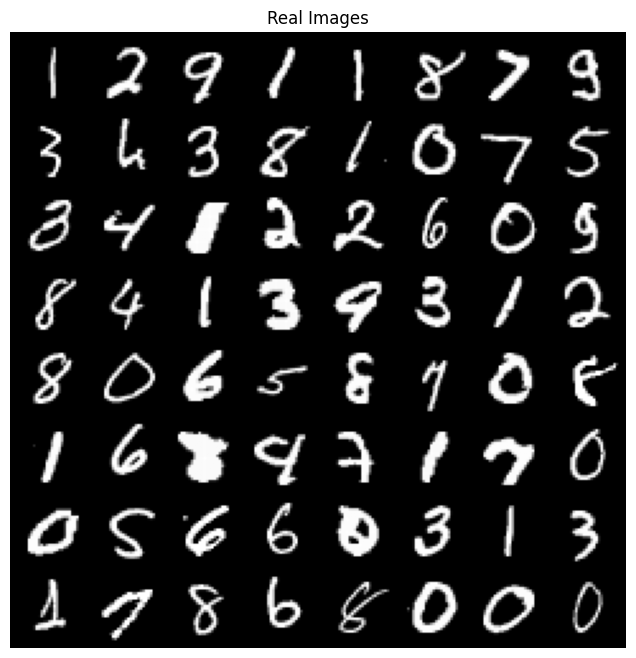

In [ ]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

# Here is the general architecture of the ViT model
## The architecture includes:
- A step for splitting the image into disjoint patches with a linear projection of the patches
- Positional encoding to capture the absolute spatial information of each patch in the image
- The addition of a "[CLS]" token, initialized randomly and learned during training
- A transformer encoder that learns the representation of each token
- A classification head that performs class prediction from the re-embedded [CLS] token at the output of the encoder

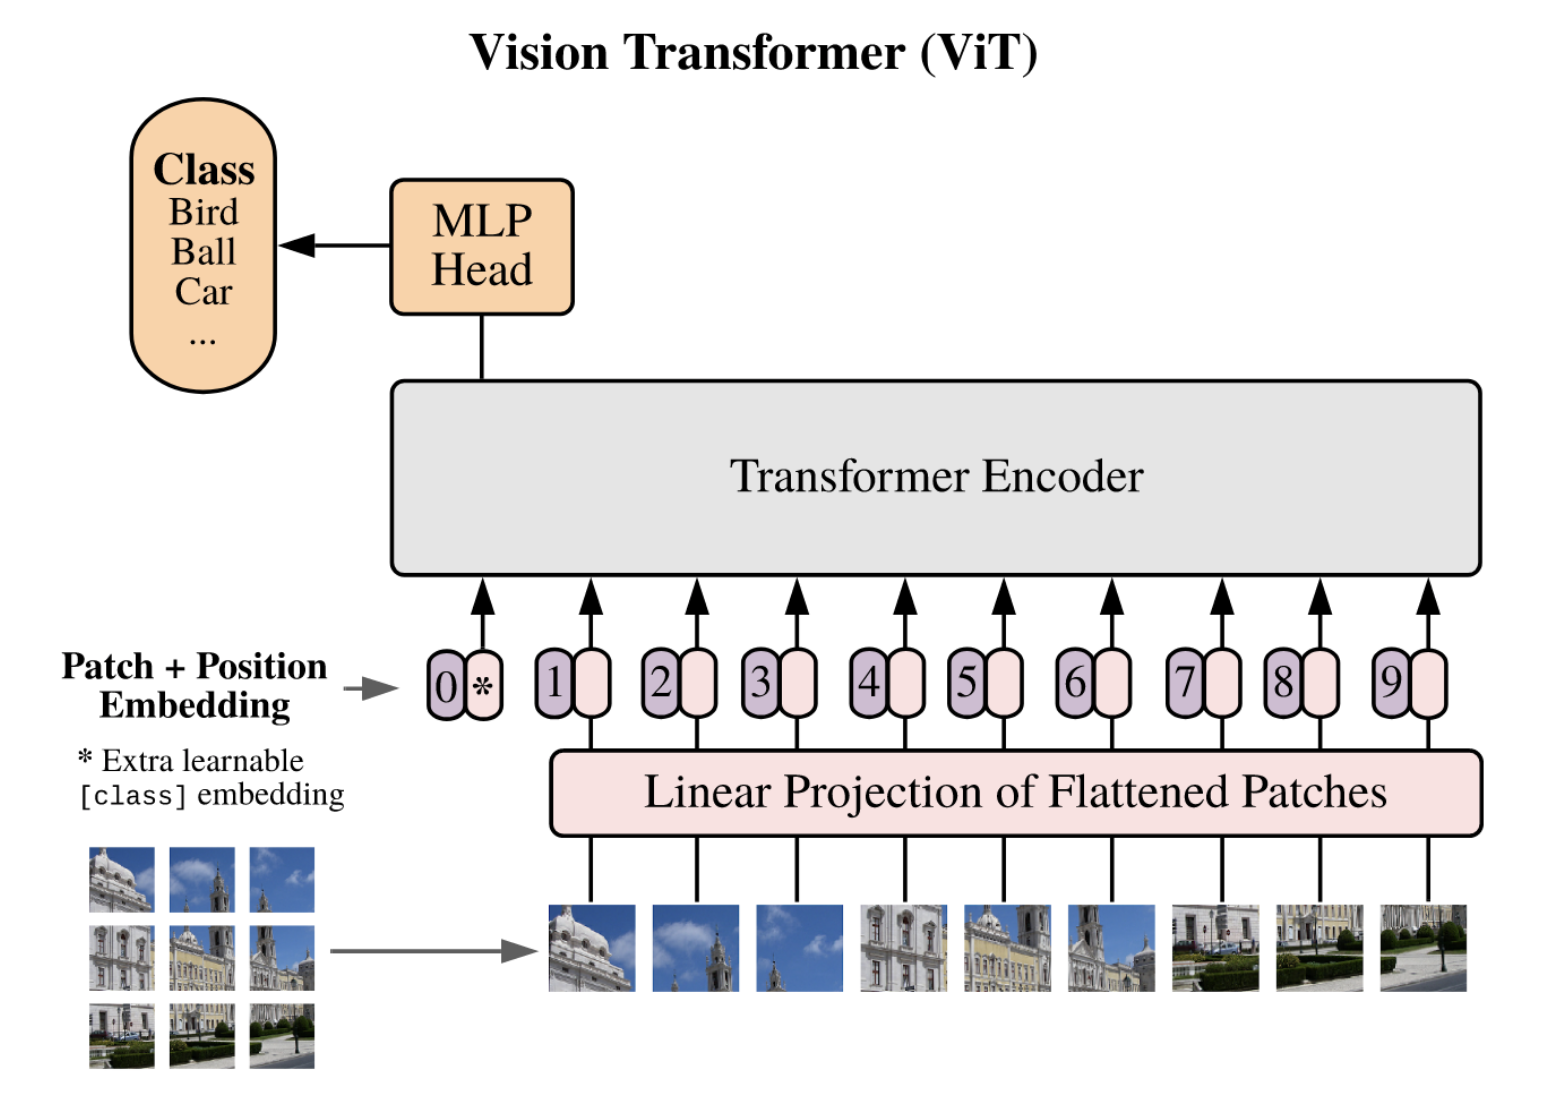

# Linear Projection of flattened patches

## Q1:

First, we need to code the patch embedding. In NLP, it could be using a word2vec embeddings, but we need something different in Computer Vision.

We are going to use a specific 2d convolution to play the role of the so-called "Linear Projection" on the image above and process each patch independently without overlap.

Then, We need to manipulate the dimensions of the resulting tensor to get a final tensor of shape `(batch_size, nb_tokens, embedding_dim)`.

In [ ]:
class PatchEmbed(nn.Module):
  def __init__(self, in_chan=1, patch_size=7, embed_dim=128):
    super().__init__()
    # Each patch goes through embed_dim convolutions to get a vector of size embed_dim
    self.projection = nn.Conv2d(in_channels=in_chan, out_channels=embed_dim,
                                kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    x = self.projection(x)
    B, C, H, W = x.shape
    # x.shape() -> B, N, C
    # N = H*W

    # B, C, H, W -> B, C, (H*W) = B, C, N
    x = x.flatten(start_dim=2, end_dim=-1) # Collapse the height and width dimensions into one

    # B, C, N -> B, N, C
    x = x.transpose(1, 2)

    return x

In [ ]:
# Testing PatchEmbed
x = torch.randn(10, 1, 28, 28)
patch_embed = PatchEmbed(patch_size=7, embed_dim=128)
print(patch_embed(x).shape)

torch.Size([10, 16, 128])


# Transformer encoder

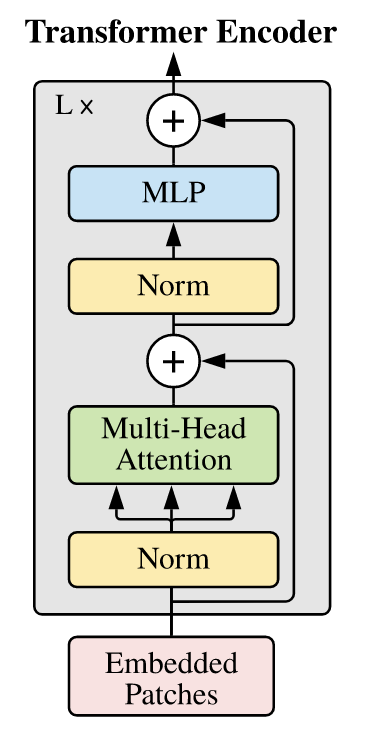

## Q2: MLP

Now we need to build a transformer block. Let's first build the easiest part, the MLP!

We code first a MLP with one hidden layer. The input and output dimensions will be the same. Instead of ReLU,  we use the activation GELU, which is a slight alternative often used for transformers.

In [ ]:
class MLP(nn.Module):
  def __init__(self, in_features, hid_features):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(in_features, hid_features),
      nn.GELU(),
      nn.Linear(hid_features, in_features)
    )

  def forward(self, x):
    x = self.layers(x)
    return x

In [ ]:
# Testing MLP
MLP(128, 512)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

## Q3: Self-attention

Now we are going to build the famous **Self-Attention**.


In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, embed_dim, model_dim=None):
    super().__init__()
    self.embed_dim = embed_dim
    if model_dim is None:
      model_dim = embed_dim
    self.model_dim = model_dim
    self.W_q = nn.Linear(model_dim, embed_dim, bias=False)
    self.W_k = nn.Linear(model_dim, embed_dim, bias=False)
    self.W_v = nn.Linear(model_dim, embed_dim, bias=False)

  def forward(self, x):
    B, N, C = x.shape

    # Compute the Q, K, V
    q = self.W_q(x)
    k = self.W_k(x)
    v = self.W_v(x)

    # Compute the attention matrix using Q and K
    scale = self.embed_dim ** -0.5
    attention = torch.bmm(q, k.transpose(1, 2)) * scale

    # Compute the final version using the attention,
    # V, and the final projection
    x = torch.bmm(F.softmax(attention, dim=2), v)

    return x

In [ ]:
# Testing SelfAttention
embed_dim = 128
model_dim = 12288
seq_len = 16
batch_size = 32
X = torch.randn(batch_size, seq_len, model_dim)
self_attn = SelfAttention(embed_dim, model_dim)
print(self_attn(X).shape)

torch.Size([32, 16, 128])


# Q4 : Multi-head self-attention

Now we need to build a Multi-Heads Self-Attention by sharing equally the total embedding size among all heads.

In [ ]:
class MultiHeadsSelfAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()

    head_dim = embed_dim // num_heads # d_k
    self.scale = head_dim ** -0.5
    self.num_heads = num_heads
    self.head_dim = head_dim
    self.embed_dim = embed_dim

    self.q = nn.Linear(embed_dim, embed_dim, bias=False)
    self.k = nn.Linear(embed_dim, embed_dim, bias=False)
    self.v = nn.Linear(embed_dim, embed_dim, bias=False)

    # Final output projection
    self.projection = nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
      B, N, C = x.shape  # Batch size, sequence length, model dimension

      # Project inputs to Q, K, V
      q = self.q(x)  # Shape: (B, N, embed_dim)
      k = self.k(x)
      v = self.v(x)

      # Reshape to (B, N, num_heads, head_dim)
      q = q.view(B, N, self.num_heads, self.head_dim)
      k = k.view(B, N, self.num_heads, self.head_dim)
      v = v.view(B, N, self.num_heads, self.head_dim)

      # Permute to (B, num_heads, N, head_dim)
      q = q.permute(0, 2, 1, 3)  # Shape: (B, num_heads, N, head_dim)
      k = k.permute(0, 2, 1, 3)
      v = v.permute(0, 2, 1, 3)

      # Compute scaled dot-product attention
      attn_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale  # Shape: (B, num_heads, N, N)
      attn_probs = attn_scores.softmax(dim=-1)  # Apply softmax over the last dimension

      # Apply attention to values
      attn_output = torch.matmul(attn_probs, v)  # Shape: (B, num_heads, N, head_dim)

      # Permute and reshape back to (B, N, embed_dim)
      attn_output = attn_output.permute(0, 2, 1, 3).contiguous()  # Shape: (B, N, num_heads, head_dim)
      attn_output = attn_output.view(B, N, self.embed_dim)  # Shape: (B, N, embed_dim)

      # Final linear projection
      output = self.projection(attn_output)  # Shape: (B, N, embed_dim)

      return output

In [ ]:
# Testing MultiHeadsSelfAttention
embed_dim = 128
seq_len = 16
batch_size = 32
num_heads = 8
X = torch.randn(batch_size, seq_len, embed_dim)
multihead_attn = MultiHeadsSelfAttention(embed_dim, num_heads)
print(multihead_attn(X).shape)

torch.Size([32, 16, 128])


# Q5: Transfomer block

Now, we need to build a Transformer **Block** as described in the image below.


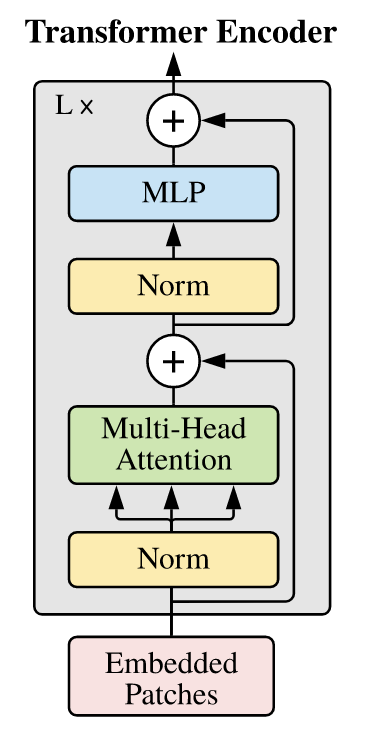

In [ ]:
class Block(nn.Module):
  def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
    super().__init__()
    self.norm1 = nn.LayerNorm(embed_dim)
    self.norm2 = nn.LayerNorm(embed_dim)
    self.attn = MultiHeadsSelfAttention(embed_dim, num_heads)
    self.mlp = MLP(in_features=embed_dim, hid_features=embed_dim*mlp_ratio)

  def forward(self, x):
    x = x + self.attn(self.norm1(x))
    x = x + self.mlp(self.norm2(x))
    return x

In [ ]:
# Testing Block
Block(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q6: Full ViT model

Now, We need to build a ViT model based on what we coded in the previous parts. There are additional components that should be coded such as the Class token, Positional embedding and the classification head.



### Sinusoidal PE


In [ ]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(1, sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            if j % 2 == 0:
                result[0, i, j] = math.sin(i / (10000 ** (j / d)))
            else:
                result[0, i, j] = math.cos(i / (10000 ** ((j - 1) / d)))
    return result

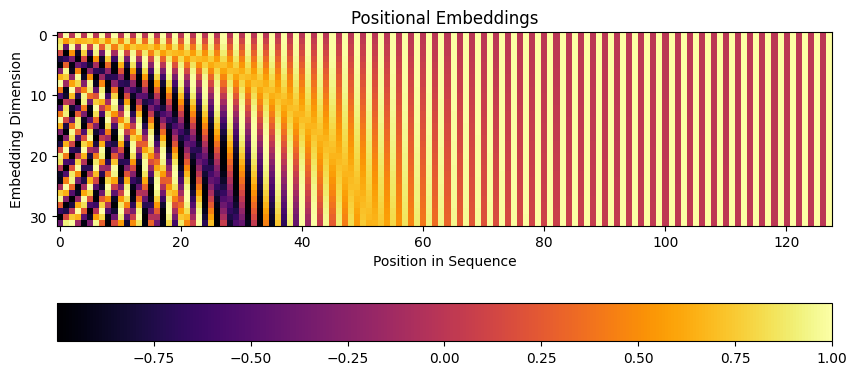

In [ ]:
# Testing get_positional_embeddings by visualizing the embeddings
d = 128
sequence_length = 32
positional_embeddings = get_positional_embeddings(sequence_length, d)

plt.figure(figsize=(10, 10))
plt.imshow(positional_embeddings[0], cmap='inferno')
plt.xlabel('Position in Sequence')
plt.ylabel('Embedding Dimension')
plt.title('Positional Embeddings')
plt.colorbar(orientation='horizontal', fraction=0.056, pad=0.1)
plt.show()

In [ ]:
class ViT(nn.Module):
  def __init__(self, embed_dim, nb_blocks, patch_size, nb_classes=10, num_heads=8, mlp_ratio=4):
    super().__init__()

    num_patches = (28 // patch_size) ** 2
    self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(get_positional_embeddings(num_patches + 1, embed_dim), requires_grad=False)
    self.patch_embed = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)

    blocks = []
    for _ in range(nb_blocks):
      blocks.append(
          Block(embed_dim, num_heads, mlp_ratio)
      )
    self.blocks = nn.Sequential(*blocks)

    self.norm = nn.LayerNorm(embed_dim)
    self.head = None
    self.head = nn.Linear(embed_dim, nb_classes)

  def forward(self, x):
    # Step 1: Embed the image patches
        x = self.patch_embed(x)  # (B, num_patches, embed_dim)

        # Step 2: Add the class token to the beginning of each sequence
        batch_size = x.shape[0]
        class_token = self.class_token.expand(batch_size, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((class_token, x), dim=1)  # (B, num_patches + 1, embed_dim)

        # Step 3: Add positional embeddings
        x = x + self.pos_embed  # (B, num_patches + 1, embed_dim)

        # Step 4: Pass through the transformer blocks
        x = self.blocks(x)  # (B, num_patches + 1, embed_dim)

        # Step 5: Normalize the output from the class token
        x = self.norm(x[:, 0])  # Extract only the class token and normalize

        # Step 6: Apply the classification head
        output = self.head(x)  # (B, nb_classes)

        return output

In [ ]:
# Testing ViT
model = ViT(embed_dim=128, nb_blocks=6, patch_size=7)
X = torch.randn(32, 1, 28, 28) # 32 images of size 28x28 with 1 channel
output = model(X)
print(output.shape)
print(torch.sum(output[0]))

torch.Size([32, 10])
tensor(-1.4098, grad_fn=<SumBackward0>)


# Q7: Experiment on MNIST!

A quick function to evaluate our model:

In [ ]:
@torch.no_grad()
def eval_model(model, loader):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

And run! Feel free to try other hyperparameters.

In [ ]:
epochs = 10

embed_dim = 32
patch_size = 7
nb_blocks = 2

model = ViT(embed_dim, nb_blocks, patch_size).cuda()
opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
  acc = eval_model(model, test_loader)
  print(f"Test accuracy: {acc}")
  print()


--- Epoch 0 ---
Train loss: 0.7286431753495609
Test accuracy: 92.7

--- Epoch 1 ---
Train loss: 0.20404026025870461
Test accuracy: 95.47

--- Epoch 2 ---
Train loss: 0.14776021202426476
Test accuracy: 95.92

--- Epoch 3 ---
Train loss: 0.119707678156748
Test accuracy: 95.96

--- Epoch 4 ---
Train loss: 0.10660785387581917
Test accuracy: 96.56

--- Epoch 5 ---
Train loss: 0.08905335347742033
Test accuracy: 97.24

--- Epoch 6 ---
Train loss: 0.07986710589927143
Test accuracy: 97.19

--- Epoch 7 ---
Train loss: 0.07161483794514305
Test accuracy: 97.33

--- Epoch 8 ---
Train loss: 0.065579531966512
Test accuracy: 97.35

--- Epoch 9 ---
Train loss: 0.05751970542797338
Test accuracy: 97.26



# Experimental analysis



Testing ViT with embed_dim=16, patch_size=7, nb_blocks=4
Epoch 1/10, Train Loss: 1.0094, Test Accuracy: 89.22%
Epoch 2/10, Train Loss: 0.2717, Test Accuracy: 93.55%
Epoch 3/10, Train Loss: 0.1894, Test Accuracy: 94.86%
Epoch 4/10, Train Loss: 0.1540, Test Accuracy: 96.24%
Epoch 5/10, Train Loss: 0.1329, Test Accuracy: 96.59%
Epoch 6/10, Train Loss: 0.1176, Test Accuracy: 96.53%
Epoch 7/10, Train Loss: 0.1060, Test Accuracy: 96.45%
Epoch 8/10, Train Loss: 0.0984, Test Accuracy: 96.37%
Epoch 9/10, Train Loss: 0.0891, Test Accuracy: 96.91%
Epoch 10/10, Train Loss: 0.0876, Test Accuracy: 96.85%

Testing ViT with embed_dim=32, patch_size=7, nb_blocks=4
Epoch 1/10, Train Loss: 0.6753, Test Accuracy: 94.89%
Epoch 2/10, Train Loss: 0.1629, Test Accuracy: 95.80%
Epoch 3/10, Train Loss: 0.1209, Test Accuracy: 96.66%
Epoch 4/10, Train Loss: 0.0949, Test Accuracy: 96.77%
Epoch 5/10, Train Loss: 0.0810, Test Accuracy: 97.28%
Epoch 6/10, Train Loss: 0.0707, Test Accuracy: 97.52%
Epoch 7/10, Train L

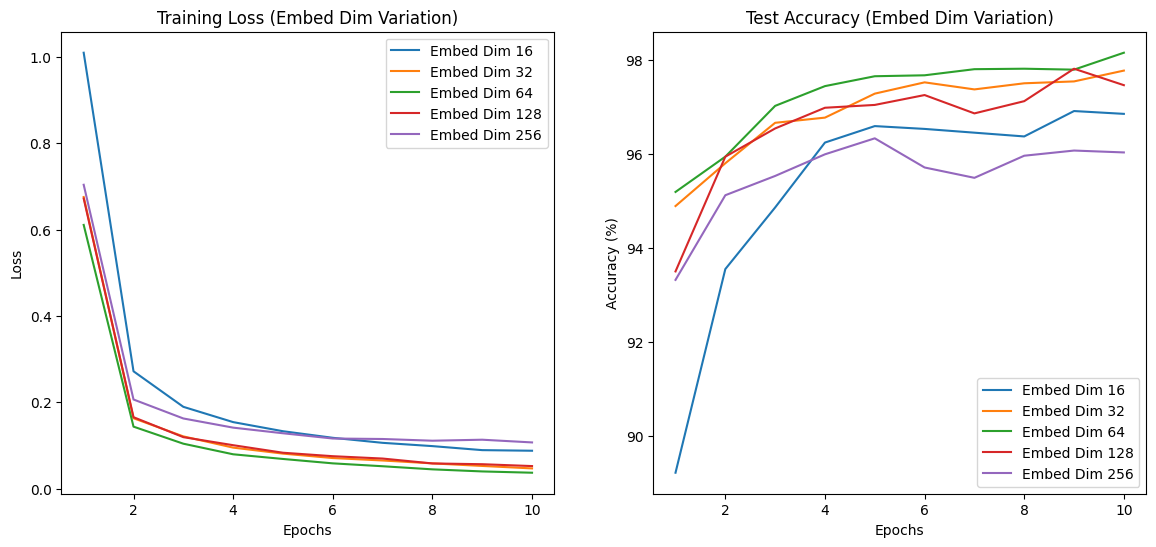


Testing ViT with embed_dim=64, patch_size=2, nb_blocks=4
Epoch 1/10, Train Loss: 0.9317, Test Accuracy: 94.59%
Epoch 2/10, Train Loss: 0.1722, Test Accuracy: 95.81%
Epoch 3/10, Train Loss: 0.1152, Test Accuracy: 96.77%
Epoch 4/10, Train Loss: 0.0922, Test Accuracy: 97.17%
Epoch 5/10, Train Loss: 0.0773, Test Accuracy: 97.48%
Epoch 6/10, Train Loss: 0.0679, Test Accuracy: 97.86%
Epoch 7/10, Train Loss: 0.0597, Test Accuracy: 97.82%
Epoch 8/10, Train Loss: 0.0517, Test Accuracy: 98.02%
Epoch 9/10, Train Loss: 0.0493, Test Accuracy: 97.83%
Epoch 10/10, Train Loss: 0.0427, Test Accuracy: 98.16%

Testing ViT with embed_dim=64, patch_size=5, nb_blocks=4
Epoch 1/10, Train Loss: 0.6229, Test Accuracy: 95.36%
Epoch 2/10, Train Loss: 0.1318, Test Accuracy: 96.56%
Epoch 3/10, Train Loss: 0.0907, Test Accuracy: 97.43%
Epoch 4/10, Train Loss: 0.0688, Test Accuracy: 97.77%
Epoch 5/10, Train Loss: 0.0608, Test Accuracy: 97.90%
Epoch 6/10, Train Loss: 0.0494, Test Accuracy: 97.90%
Epoch 7/10, Train L

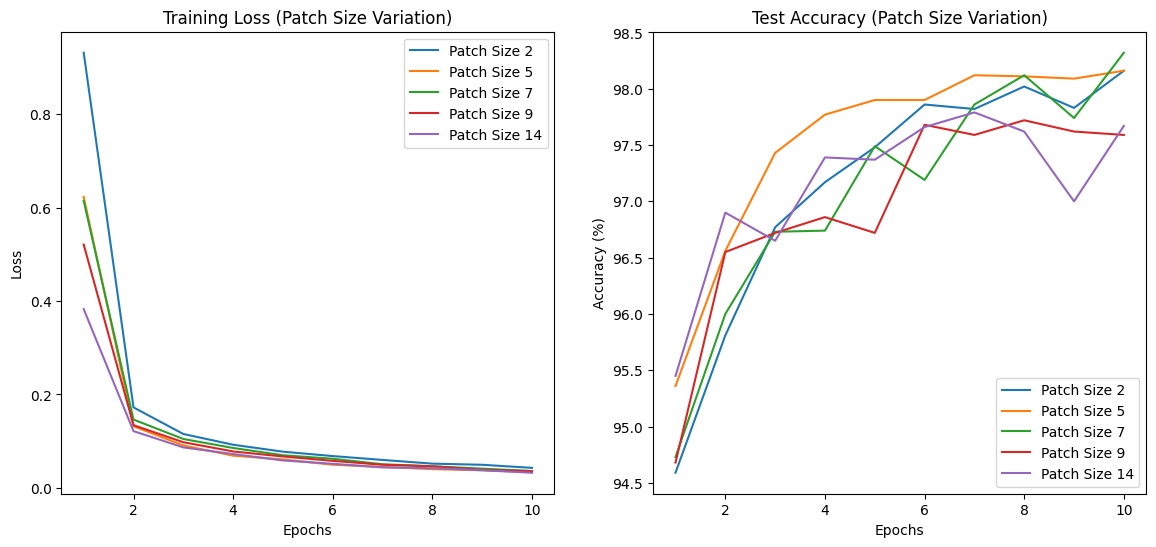


Testing ViT with embed_dim=64, patch_size=7, nb_blocks=2
Epoch 1/10, Train Loss: 0.5401, Test Accuracy: 94.77%
Epoch 2/10, Train Loss: 0.1371, Test Accuracy: 97.14%
Epoch 3/10, Train Loss: 0.0993, Test Accuracy: 97.30%
Epoch 4/10, Train Loss: 0.0762, Test Accuracy: 97.14%
Epoch 5/10, Train Loss: 0.0644, Test Accuracy: 97.39%
Epoch 6/10, Train Loss: 0.0574, Test Accuracy: 97.43%
Epoch 7/10, Train Loss: 0.0512, Test Accuracy: 97.86%
Epoch 8/10, Train Loss: 0.0443, Test Accuracy: 97.35%
Epoch 9/10, Train Loss: 0.0395, Test Accuracy: 97.97%
Epoch 10/10, Train Loss: 0.0353, Test Accuracy: 98.24%

Testing ViT with embed_dim=64, patch_size=7, nb_blocks=4
Epoch 1/10, Train Loss: 0.6113, Test Accuracy: 95.12%
Epoch 2/10, Train Loss: 0.1382, Test Accuracy: 95.98%
Epoch 3/10, Train Loss: 0.0967, Test Accuracy: 97.02%
Epoch 4/10, Train Loss: 0.0763, Test Accuracy: 97.41%
Epoch 5/10, Train Loss: 0.0653, Test Accuracy: 97.50%
Epoch 6/10, Train Loss: 0.0577, Test Accuracy: 97.41%
Epoch 7/10, Train L

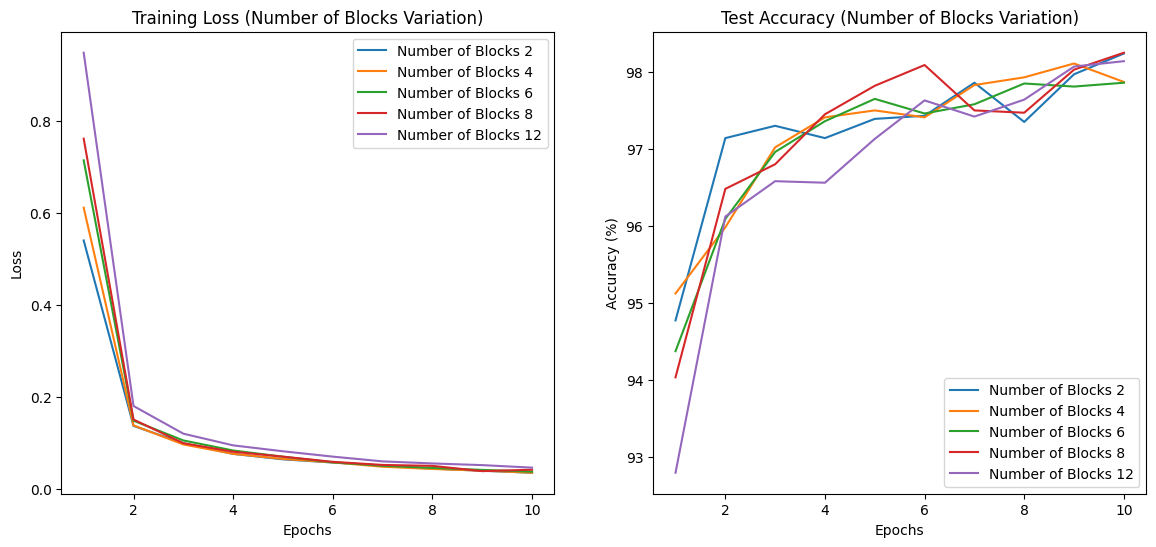


Testing ViT with embed_dim=2, patch_size=7, nb_blocks=7
Epoch 1/10, Train Loss: 0.6911, Test Accuracy: 93.41%
Epoch 2/10, Train Loss: 0.1738, Test Accuracy: 95.27%
Epoch 3/10, Train Loss: 0.1264, Test Accuracy: 97.01%
Epoch 4/10, Train Loss: 0.0980, Test Accuracy: 96.84%
Epoch 5/10, Train Loss: 0.0819, Test Accuracy: 97.11%
Epoch 6/10, Train Loss: 0.0736, Test Accuracy: 96.23%
Epoch 7/10, Train Loss: 0.0634, Test Accuracy: 97.25%
Epoch 8/10, Train Loss: 0.0566, Test Accuracy: 97.50%
Epoch 9/10, Train Loss: 0.0492, Test Accuracy: 97.51%
Epoch 10/10, Train Loss: 0.0467, Test Accuracy: 97.67%

Testing ViT with embed_dim=4, patch_size=7, nb_blocks=7
Epoch 1/10, Train Loss: 0.7076, Test Accuracy: 91.46%
Epoch 2/10, Train Loss: 0.1638, Test Accuracy: 95.50%
Epoch 3/10, Train Loss: 0.1183, Test Accuracy: 96.83%
Epoch 4/10, Train Loss: 0.0929, Test Accuracy: 96.67%
Epoch 5/10, Train Loss: 0.0794, Test Accuracy: 97.26%
Epoch 6/10, Train Loss: 0.0683, Test Accuracy: 96.99%
Epoch 7/10, Train Los

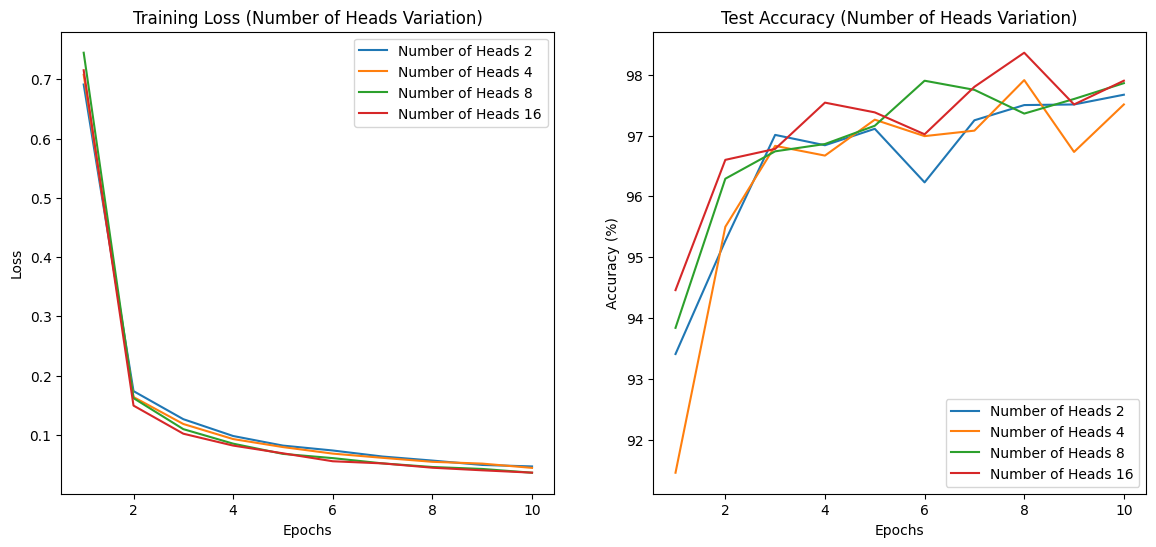


Testing ViT with embed_dim=64, patch_size=7, nb_blocks=7, mlp=1
Epoch 1/10, Train Loss: 0.5839, Test Accuracy: 93.57%
Epoch 2/10, Train Loss: 0.1510, Test Accuracy: 95.77%
Epoch 3/10, Train Loss: 0.1076, Test Accuracy: 96.23%
Epoch 4/10, Train Loss: 0.0886, Test Accuracy: 97.08%
Epoch 5/10, Train Loss: 0.0718, Test Accuracy: 97.11%
Epoch 6/10, Train Loss: 0.0640, Test Accuracy: 97.27%
Epoch 7/10, Train Loss: 0.0563, Test Accuracy: 97.33%
Epoch 8/10, Train Loss: 0.0518, Test Accuracy: 97.64%
Epoch 9/10, Train Loss: 0.0461, Test Accuracy: 97.57%
Epoch 10/10, Train Loss: 0.0406, Test Accuracy: 97.42%

Testing ViT with embed_dim=64, patch_size=7, nb_blocks=7, mlp=2
Epoch 1/10, Train Loss: 0.6622, Test Accuracy: 94.96%
Epoch 2/10, Train Loss: 0.1442, Test Accuracy: 96.57%
Epoch 3/10, Train Loss: 0.1011, Test Accuracy: 97.36%
Epoch 4/10, Train Loss: 0.0782, Test Accuracy: 97.13%
Epoch 5/10, Train Loss: 0.0644, Test Accuracy: 97.26%
Epoch 6/10, Train Loss: 0.0590, Test Accuracy: 97.81%
Epoch

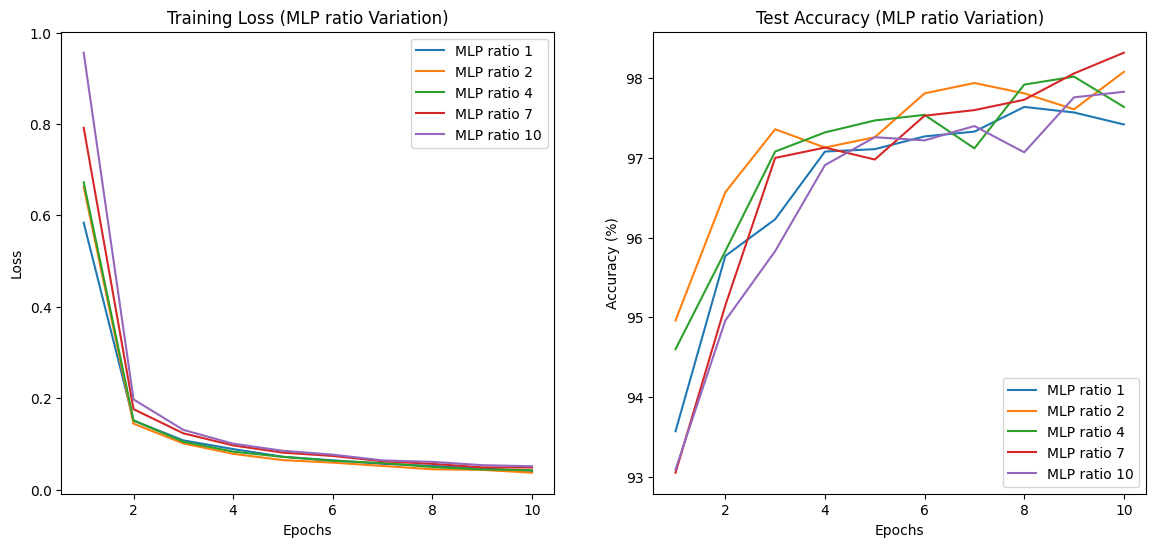

In [ ]:
# Define the training function that logs the loss and accuracy per epoch
def train_model(model, train_loader, test_loader, epochs=25):
    model = model.cuda()
    optimizer = torch.optim.Adam(model.parameters())
    train_losses, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            yhat = model(x)
            loss = F.cross_entropy(yhat, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        test_accuracy = eval_model(model, test_loader)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return train_losses, test_accuracies

# Plot the loss and accuracy curves
def plot_curves_multiple(train_losses_dict, test_accuracies_dict, hyperparam_name, embed_dim=None, patch_size=None, nb_blocks=None):
    epochs = range(1, len(next(iter(train_losses_dict.values()))) + 1)  # Get the number of epochs

    plt.figure(figsize=(14, 6))

    # Plot training loss for each hyperparameter value
    plt.subplot(1, 2, 1)
    for hyperparam_value, train_losses in train_losses_dict.items():
        plt.plot(epochs, train_losses, label=f'{hyperparam_name} {hyperparam_value}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Loss ({hyperparam_name} Variation)')
    plt.legend()

    # Plot test accuracy for each hyperparameter value
    plt.subplot(1, 2, 2)
    for hyperparam_value, test_accuracies in test_accuracies_dict.items():
        plt.plot(epochs, test_accuracies, label=f'{hyperparam_name} {hyperparam_value}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Test Accuracy ({hyperparam_name} Variation)')
    plt.legend()

    plt.show()

embeds_dim = [16, 32, 64, 128, 256]
nb_blocks = 4
patch_sizes = 7
train_losses_dict = {}
test_accuracies_dict = {}

for embed_dim in embeds_dim:
    print(f"\nTesting ViT with embed_dim={embed_dim}, patch_size={patch_size}, nb_blocks={nb_blocks}")

    model = ViT(embed_dim=embed_dim, nb_blocks=nb_blocks, patch_size=patch_size)
    train_losses, test_accuracies = train_model(model, train_loader, test_loader, epochs=10)

    train_losses_dict[embed_dim] = train_losses
    test_accuracies_dict[embed_dim] = test_accuracies

plot_curves_multiple(train_losses_dict, test_accuracies_dict, "Embed Dim", patch_size=patch_size, nb_blocks=nb_blocks)


embed_dim = 64
nb_blocks = 4
patch_sizes = [2, 5, 7, 9 , 14]

train_losses_dict = {}
test_accuracies_dict = {}

for patch_size in patch_sizes:
    print(f"\nTesting ViT with embed_dim={embed_dim}, patch_size={patch_size}, nb_blocks={nb_blocks}")

    model = ViT(embed_dim=embed_dim, nb_blocks=nb_blocks, patch_size=patch_size)
    train_losses, test_accuracies = train_model(model, train_loader, test_loader, epochs=10)

    train_losses_dict[patch_size] = train_losses
    test_accuracies_dict[patch_size] = test_accuracies

plot_curves_multiple(train_losses_dict, test_accuracies_dict, "Patch Size", embed_dim=embed_dim, nb_blocks=nb_blocks)

embed_dim = 64
patch_size = 7
nb_blocks_options = [2, 4, 6, 8 , 12]

train_losses_dict = {}
test_accuracies_dict = {}

for nb_blocks in nb_blocks_options:
    print(f"\nTesting ViT with embed_dim={embed_dim}, patch_size={patch_size}, nb_blocks={nb_blocks}")

    model = ViT(embed_dim=embed_dim, nb_blocks=nb_blocks, patch_size=patch_size)
    train_losses, test_accuracies = train_model(model, train_loader, test_loader, epochs=10)

    train_losses_dict[nb_blocks] = train_losses
    test_accuracies_dict[nb_blocks] = test_accuracies

plot_curves_multiple(train_losses_dict, test_accuracies_dict, "Number of Blocks", embed_dim=embed_dim, patch_size=patch_size)

num_heads = [2, 4, 8, 16]
embed_dim = 64
nb_blocks = 7
mlp=4
patch_size = 7
train_losses_dict = {}
test_accuracies_dict = {}

for num_head in num_heads :
    print(f"\nTesting ViT with embed_dim={num_head}, patch_size={patch_size}, nb_blocks={nb_blocks}")

    model = ViT(embed_dim=embed_dim, nb_blocks=nb_blocks, patch_size=patch_size ,nb_classes=10, num_heads=num_head, mlp_ratio=mlp )
    train_losses, test_accuracies = train_model(model, train_loader, test_loader, epochs=10)

    train_losses_dict[num_head] = train_losses
    test_accuracies_dict[num_head] = test_accuracies

plot_curves_multiple(train_losses_dict, test_accuracies_dict, "Number of Heads", patch_size=patch_size, nb_blocks=nb_blocks)

num_head = 4
embed_dim = 64
nb_blocks = 7
mlps=[1,2,4,7,10]
patch_sizes = 7
train_losses_dict = {}
test_accuracies_dict = {}

for mlp in mlps :
    print(f"\nTesting ViT with embed_dim={embed_dim}, patch_size={patch_size}, nb_blocks={nb_blocks}, mlp={mlp}")

    model = ViT(embed_dim=embed_dim, nb_blocks=nb_blocks, patch_size=patch_size ,nb_classes=10, num_heads=num_head, mlp_ratio=mlp )
    train_losses, test_accuracies = train_model(model, train_loader, test_loader, epochs=10)

    train_losses_dict[mlp] = train_losses
    test_accuracies_dict[mlp] = test_accuracies

plot_curves_multiple(train_losses_dict, test_accuracies_dict, "MLP ratio", patch_size=patch_size, nb_blocks=nb_blocks)

# Q8: larger transformers

In [ ]:
%pip install timm

In [ ]:
import timm

model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=10)

In [ ]:
x = torch.randn(32, 1, 28, 28)

# Resize the image to 224x224
x = F.interpolate(x, size=(224, 224))

# adapt number of channels to fit in ViT
x = x.repeat(1, 3, 1, 1)

model(x).shape

torch.Size([32, 10])

In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=10, in_chans=1, img_size=28)
model(torch.randn(32, 1, 28, 28)).shape

torch.Size([32, 10])

In [ ]:
@torch.no_grad()
def eval_model(model, loader, num_channels=1):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    # adapt number of channels to fit in ViT
    # not needed when using in_chans=1 in the model definition
    # x = x.repeat(1, num_channels, 1, 1)

    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

In [ ]:
model.cuda()
model.train()

epochs = 10

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    # adapt number of channels to fit in ViT
    # not needed when using in_chans=1 in the model definition
    # x = x.repeat(1, 3, 1, 1)
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
  acc = eval_model(model, test_loader, num_channels=3)
  print(f"Test accuracy: {acc}")
  print()

acc = eval_model(model, test_loader, num_channels=3)
print(f"Test accuracy: {acc}")

--- Epoch 0 ---
Train loss: 1.1531579376283738
Test accuracy: 80.25

--- Epoch 1 ---
Train loss: 0.5828345386839625
Test accuracy: 83.13

--- Epoch 2 ---
Train loss: 0.5132750723916076
Test accuracy: 84.12

--- Epoch 3 ---
Train loss: 0.483047245916273
Test accuracy: 86.09

--- Epoch 4 ---
Train loss: 0.44659341131446206
Test accuracy: 85.97

--- Epoch 5 ---
Train loss: 0.4217420717292249
Test accuracy: 86.28

--- Epoch 6 ---
Train loss: 0.4078125348413931
Test accuracy: 87.17

--- Epoch 7 ---
Train loss: 0.39837557608003554
Test accuracy: 86.19

--- Epoch 8 ---
Train loss: 0.3856965808916702
Test accuracy: 86.46

--- Epoch 9 ---
Train loss: 0.3752736715810385
Test accuracy: 87.02

Test accuracy: 87.02


In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=10, in_chans=1, img_size=28).cuda()

epochs = 10
opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    # x = None # adapt number of channels to fit in ViT
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
  acc = eval_model(model, test_loader, num_channels=3)
  print(f"Test accuracy: {acc}")
  print()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

--- Epoch 0 ---
Train loss: 0.8418114091922988
Test accuracy: 85.55

--- Epoch 1 ---
Train loss: 0.43481569869050596
Test accuracy: 87.22

--- Epoch 2 ---
Train loss: 0.3711537272691218
Test accuracy: 89.28

--- Epoch 3 ---
Train loss: 0.34705615463033157
Test accuracy: 89.3

--- Epoch 4 ---
Train loss: 0.32747240850666187
Test accuracy: 89.87

--- Epoch 5 ---
Train loss: 0.3075611695551923
Test accuracy: 89.66

--- Epoch 6 ---
Train loss: 0.3011416319463807
Test accuracy: 89.48

--- Epoch 7 ---
Train loss: 0.29810177390255144
Test accuracy: 89.75

--- Epoch 8 ---
Train loss: 0.2861431620236653
Test accuracy: 88.65

--- Epoch 9 ---
Train loss: 0.29358708755230345
Test accuracy: 89.88

